In [2]:
import pyodbc

In [7]:
connection = conn = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=LAPTOP-U3J291UT;DATABASE=BI_ETL;Trusted_Connection=yes;')

In [15]:
#cursor = connection.cursor() 
SQL = "SELECT[all_data_id]" +\
      ",[sourceId]" +\
      ",[referenceTime]" +\
      ",[air_temperature]" +\
      ",[wind_speed]" +\
      ",[wind_from_direction]" +\
      ",[air_pressure_at_sea_level]" +\
      ",[cloud_area_fraction]" +\
      ",[bool_cloud_area_fraction_1D]" +\
      ",[precipitation_amount_1H]" +\
      "FROM [BI_ETL].[dbo].[all_measurements]"

import pandas as pd
df = pd.read_sql(SQL, connection)

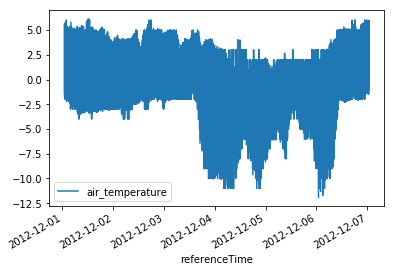

In [21]:
df.plot(x='referenceTime', y='air_temperature')

In [26]:
import seaborn as sns

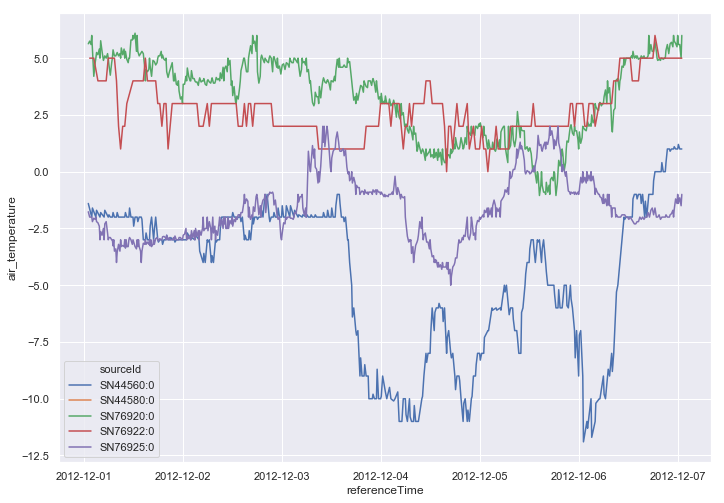

In [30]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="referenceTime", y="air_temperature",
             hue="sourceId",
             data=df)

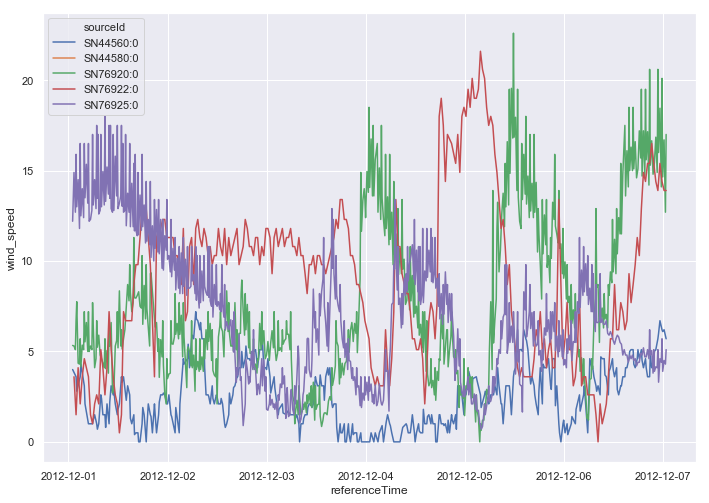

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="referenceTime", y="wind_speed",
             hue="sourceId",
             data=df)